In [142]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import sys
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import logsumexp
sys.path.append('../')

In [144]:
import torch
from dataManipulation import *
from treeManipulation import *
from utils import tree_summary, summary, summary_raw, get_support_info
from vbpi import VBPI

# change the file names

In [4]:
#for i in range(1,11):
#    os.rename('../data/DS1/DS1_fixed_support_short_run_rep_%d.trees'%i,
#              '../data/DS1/DS1_fixed_pop_support_short_run_rep_%d.trees'%i)

In [7]:
# load the sequence data and estimate the subsplit support
data, taxa = loadData('../data/DS1/DS1.nexus', 'nexus')
mcmc_support_trees_dict, mcmc_support_trees_wts = summary('../data/DS1/DS1_fixed_pop_support_short_run', 'nexus', burnin=2501)
rootsplit_supp_dict, subsplit_supp_dict = get_support_info(taxa, mcmc_support_trees_dict)
del mcmc_support_trees_dict, mcmc_support_trees_wts

In [8]:
# load the ground truth
mcmc_sampled_trees_dict, mcmc_sampled_trees_wts, _ = tree_summary('../data/DS1/DS1_fixed_pop_golden_run.trees', 'nexus', burnin=25001)
emp_tree_freq = {mcmc_sampled_trees_dict[tree_id]: tree_wts for tree_id, tree_wts in sorted(mcmc_sampled_trees_wts.items(), key=lambda x:x[1], reverse=True)}
sample_info = [0.0 for taxon in taxa]
del mcmc_sampled_trees_dict, mcmc_sampled_trees_wts

In [151]:
# set up the model
model = VBPI(taxa, rootsplit_supp_dict, subsplit_supp_dict, data, pden=np.ones(4)/4., subModel=('JC', 1.0),
             emp_tree_freq=emp_tree_freq, root_height_offset=0.0, clock_rate=1.0, psp=True,
             sample_info=sample_info, coalescent_type='fixed_pop', clock_type='fixed_rate',
             log_pop_size_offset=math.log(5.0))

In [152]:
# variational parameters
for param in model.parameters():
    print(param.dtype, param.size())

torch.float32 torch.Size([140])
torch.float32 torch.Size([524, 2])


In [153]:
# run vbpi.
# the trained model will be saved to 'results/DENV4/mcmc_vimco_10_psp_constant_fixed.pt'.
test_lb, test_kl_div = model.learn(0.001, maxiter=200000, n_particles=10, warm_start_interval=50000, method='vimco',
                                   save_to_path='../results/DS1/mcmc_vimco_10_psp_fixed_fixed.pt')

Iter 1000:(106.1s) Lower Bound: -8414.6501 | Logll: -8896.1006 | Root Age: 0.9224 | KL: 9.783557
>>> Iter 1000:(4.7s) Test Lower Bound: -11560.9277
Iter 2000:(95.2s) Lower Bound: -7403.1933 | Logll: -7478.5312 | Root Age: 0.3401 | KL: 8.276013
>>> Iter 2000:(4.1s) Test Lower Bound: -8934.8213
Iter 3000:(93.4s) Lower Bound: -7281.6233 | Logll: -7361.5552 | Root Age: 0.1656 | KL: 7.257765
>>> Iter 3000:(4.2s) Test Lower Bound: -8175.1851
Iter 4000:(94.0s) Lower Bound: -7248.4544 | Logll: -7097.4102 | Root Age: 0.1196 | KL: 5.294879
>>> Iter 4000:(4.1s) Test Lower Bound: -7762.1245
Iter 5000:(94.7s) Lower Bound: -7226.6334 | Logll: -7104.8911 | Root Age: 0.0899 | KL: 4.949825
>>> Iter 5000:(4.2s) Test Lower Bound: -7485.5205
Iter 6000:(366.2s) Lower Bound: -7211.0780 | Logll: -7084.0469 | Root Age: 0.0720 | KL: 4.455956
>>> Iter 6000:(6.3s) Test Lower Bound: -7395.8945
Iter 7000:(149.7s) Lower Bound: -7199.8002 | Logll: -7040.4834 | Root Age: 0.0635 | KL: 4.443923
>>> Iter 7000:(7.5s) Tes

Exception: Invalid rootsplit probability! Check rs_params:(max nan, min nan)

In [145]:
# load a trained model/checkpoint for test
model.load_from('../results/DS1/mcmc_vimco_10_psp_fixed_pop_fixed_rate_2024-11-26_19_49_34.068934.pt')

In [14]:
np.load('../results/DS1/mcmc_vimco_10_psp_fixed_pop_fixed_rate_2024-11-26_test_lb.npy')

array([-16098.00976562, -13190.9921875 , -10138.46191406,  -8504.05664062,
        -8131.78759766,  -7754.76708984,  -8187.24511719,  -8507.94921875,
        -8785.58984375,  -9474.33789062,  -9207.30566406,  -9120.28613281,
        -8945.48730469,  -9037.68945312,  -8896.58886719,  -8920.25292969,
        -9098.67871094,  -9029.18554688,  -8638.98730469,  -8606.37988281,
        -8828.54980469,  -8825.79785156,  -8360.1640625 ,  -8431.23144531,
        -8543.99316406,  -8134.71630859,  -8350.71875   ,  -8268.02539062,
        -8298.02832031,  -8059.04101562,  -8053.03466797,  -7948.20068359,
        -7900.46337891,  -7940.06347656,  -7905.86035156,  -7881.78857422,
        -7869.36181641,  -7803.26464844,  -7800.10009766,  -7856.1328125 ])

In [146]:
model.lower_bound(n_particles=1,n_runs=1000)

-7838.38818359375

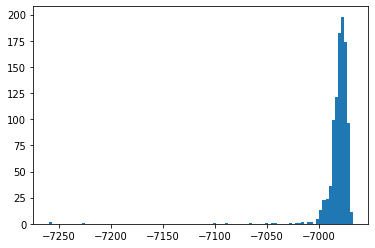

In [107]:
plt.hist(model.sample_tree_loglikelihood(n_rep = 1000).detach().numpy(),bins = 100)
plt.show()

# Get marginal Log-likelihood from importance sampling

In [108]:
def lower_bound(self, n_particles=1, n_runs=1000):
    lls = []
    priors = []
    logq_trees = []
    logq_heights = []
    logq_priors = []
    logq_clock_rates = []
    with torch.no_grad():
        for run in range(n_runs):
            samp_trees = [self.tree_model.sample_tree() for particle in range(n_particles)]
            [namenum(tree, self.taxa) for tree in samp_trees]
            logq_tree = torch.stack([self.logq_tree(tree) for tree in samp_trees])

            samp_branch, logq_height, height, event_info = self.branch_model(samp_trees)
            log_clock_rate, logq_clock_rate = self.clock_model.sample(n_particles=n_particles)
            samp_branch = samp_branch * log_clock_rate.exp()
            logll = torch.stack([self.phylo_model.loglikelihood(branch, tree) for branch, tree in zip(*[samp_branch, samp_trees])])

            self.tree_prior_model.update_batch(height, event_info)
            coalescent_param, logq_prior = self.tree_prior_model.sample_pop_size(n_particles=n_particles)
            logp_coalescent_prior, _ = self.tree_prior_model(coalescent_param, False)

            logp_clock_rate = self.clock_model(log_clock_rate)

            # comment out parts of the lower bound as needed
            lls.append(logll)         
            priors.append(logp_coalescent_prior + logp_clock_rate)
            logq_trees.append(logq_tree)
            logq_heights.append(logq_height)
            logq_priors.append(logq_prior)
            logq_clock_rates.append(logq_clock_rate)
            
        lls = torch.stack(lls).numpy().flatten()
        priors = torch.stack(priors).numpy().flatten()
        logq_trees = torch.stack(logq_trees).numpy().flatten()
        logq_heights = torch.stack(logq_heights).numpy().flatten()
        #logq_priors = torch.stack(logq_priors).numpy().flatten()
        #logq_clock_rates = torch.stack(logq_clock_rates).numpy().flatten()

    return lls,priors,logq_trees,logq_heights,logq_priors,logq_clock_rates

In [109]:
lls,priors,logq_trees,logq_heights,logq_priors,logq_clock_rates = lower_bound(model)

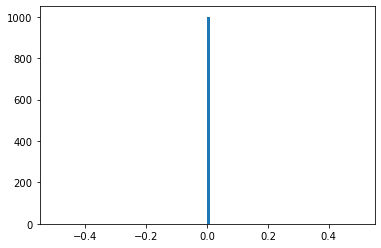

In [110]:
plt.hist(logq_clock_rates,bins=100)
plt.show()

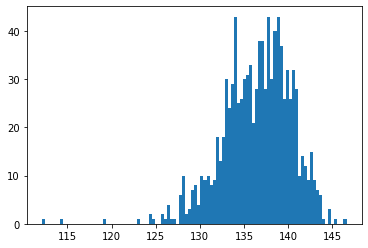

In [111]:
plt.hist(logq_heights,bins=100)
plt.show()

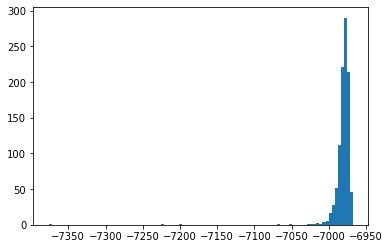

-6981.492


In [115]:
plt.hist(lls,bins = 100)
plt.show()
print(np.mean(lls))

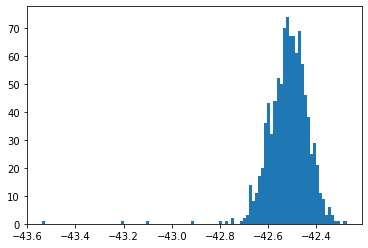

-42.51643


In [116]:
plt.hist(priors,bins = 100)
plt.show()
print(np.mean(priors))

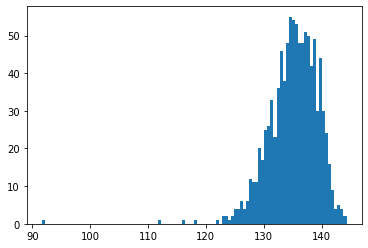

In [117]:
plt.hist(log_qs,bins = 100)
plt.show()
#plt.xlims([-7200,-7100])

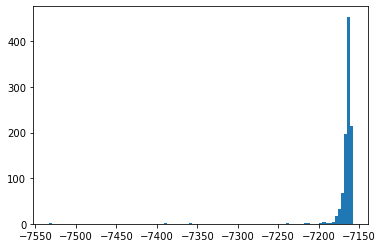

ELBO:  -7158.912
MLL:  -7154.720255278982


In [125]:
plt.hist(lls+priors-logq_heights-logq_trees - np.log(1000),bins = 100)
plt.show()
print("ELBO: ", np.mean(lls+priors-logq_heights-logq_trees))
print("MLL: ", logsumexp(lls+priors-logq_heights-logq_trees) - np.log(1000))